In [1]:
import gc
import torch
import sys

gc.collect()
torch.cuda.empty_cache()

In [2]:
!pip install rouge_score
!pip install datasets==1.0.2
!pip install transformers==4.24.0
!pip install transformer-utils
!pip install packaging
!pip install wandb

In [3]:
# 필요한 라이브러리 불러오기
import datasets
import transformers
import pandas as pd
from datasets import Dataset



import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    LineByLineTextDataset,
    BartTokenizer,
    BartForConditionalGeneration,
    

)

from transformers import RobertaTokenizerFast
from transformers import EncoderDecoderModel
from dataclasses import dataclass, field
from typing import Optional
from datasets import load_dataset, load_from_disk
from tqdm import tqdm
from tabulate import tabulate


In [4]:
model_checkpoints = "/aiffel/aiffel/Korean_Conversation_Summary/MLM_pretrain_8ep/checkpoint-140000"#"gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)

In [5]:
train_category_path = "data/train_category.csv"
val_category_path = "data/val_category.csv"

with open(train_category_path, encoding="utf-8") as f:
            train_category = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

with open(val_category_path, encoding="utf-8") as f:
            val_category = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

In [6]:
train_textfile_path = "data/train_text.csv"
train_summaryfile_path = "data/train_summary.csv"

with open(train_textfile_path, encoding="utf-8") as f:
            train_textlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

with open(train_summaryfile_path, encoding="utf-8") as f:
            train_sumlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]          

In [7]:
val_textfile_path = "data/val_text.csv"
val_summaryfile_path = "data/val_summary.csv"

with open(val_textfile_path, encoding="utf-8") as f:
            val_textlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

with open(val_summaryfile_path, encoding="utf-8") as f:
            val_sumlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]          

In [8]:
del train_textlines[0]
del val_textlines[0]
del train_category[0]
del val_category[0]
del val_sumlines[0]
del train_sumlines[0]

In [9]:
for i in range(len(val_textlines)):
    temp_cat = "#"+val_category[i]+"# "
    val_textlines[i] = temp_cat+val_textlines[i]
   

In [10]:
for i in range(len(train_textlines)):
    temp_cat = "#"+train_category[i]+"# "
    train_textlines[i] = temp_cat+train_textlines[i]

In [11]:
def get_median(a):
    a.sort()
    centerIndex = len(a) // 2 
    if len(a)% 2 == 1:
        return a[centerIndex ]
    return ((a[centerIndex - 1] + a[centerIndex ]) / 2)

train_text 최소 길이 : 3
train_text 최대 길이 : 498
train_text 평균 길이 : 30.295701305751592
train text 중앙값 :  27.0
train_summary 최소 길이 : 3
train_summary 최대 길이 : 44
train_summary 평균 길이 : 10.820741306894483
train_summary 중앙값 :  10.0


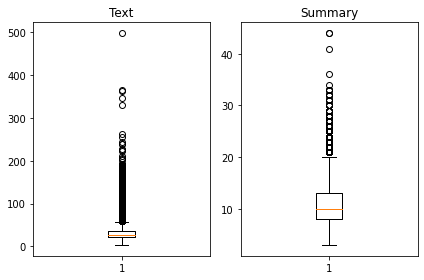

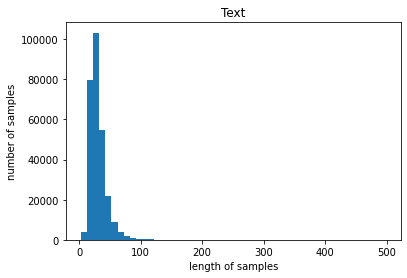

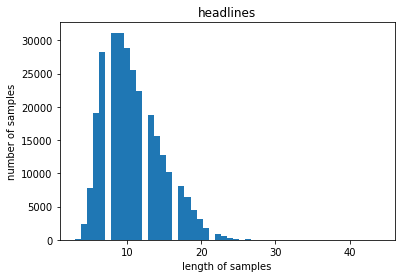

In [12]:
import matplotlib.pyplot as plt

train_text= [len(s.split()) for s in train_textlines]
train_summary = [len(s.split()) for s in train_sumlines]

print('train_text 최소 길이 : {}'.format(np.min(train_text)))
print('train_text 최대 길이 : {}'.format(np.max(train_text)))
print('train_text 평균 길이 : {}'.format(np.mean(train_text)))
print("train text 중앙값 : ",get_median(train_text))

print('train_summary 최소 길이 : {}'.format(np.min(train_summary)))
print('train_summary 최대 길이 : {}'.format(np.max(train_summary)))
print('train_summary 평균 길이 : {}'.format(np.mean(train_summary)))
print("train_summary 중앙값 : ",get_median(train_summary))

plt.subplot(1,2,1)
plt.boxplot(train_text)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(train_summary)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(train_text, bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(train_summary, bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

train_text 최소 길이 : 9
train_text 최대 길이 : 249
train_text 평균 길이 : 30.39258370471946
train text 중앙값 :  28.0
val_summary 최소 길이 : 2
val_summary 최대 길이 : 32
val_summary 평균 길이 : 10.81742086618672
val_summary 중앙값 :  10.0


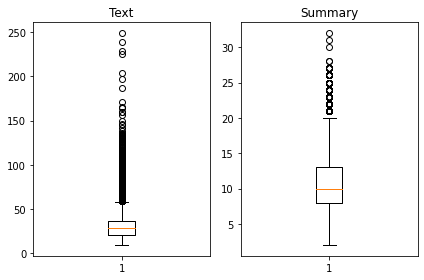

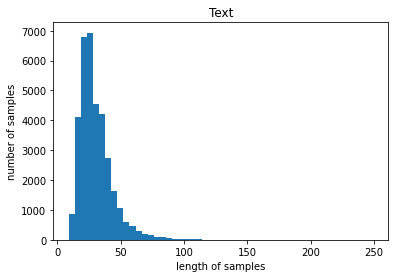

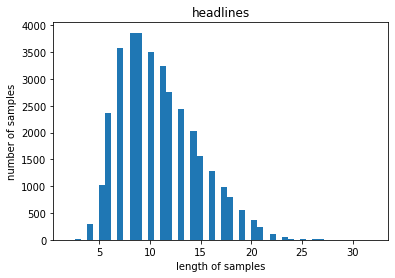

In [13]:
import matplotlib.pyplot as plt

val_text= [len(s.split()) for s in val_textlines]
val_summary = [len(s.split()) for s in val_sumlines]

print('train_text 최소 길이 : {}'.format(np.min(val_text)))
print('train_text 최대 길이 : {}'.format(np.max(val_text)))
print('train_text 평균 길이 : {}'.format(np.mean(val_text)))
print("train text 중앙값 : ",get_median(val_text))

print('val_summary 최소 길이 : {}'.format(np.min(val_summary)))
print('val_summary 최대 길이 : {}'.format(np.max(val_summary)))
print('val_summary 평균 길이 : {}'.format(np.mean(val_summary)))
print("val_summary 중앙값 : ",get_median(val_summary))

plt.subplot(1,2,1)
plt.boxplot(val_text)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(val_summary)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(val_text, bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(val_summary, bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
train_df = pd.DataFrame(zip(train_textlines, train_sumlines), columns=['Text', 'Summary'])
val_df = pd.DataFrame(zip(val_textlines, val_sumlines), columns=['Text', 'Summary'])

In [15]:
train_df.head()

,Text,Summary
0,#상거래(쇼핑)# 그럼 날짜는 가격 큰 변동 없으면 6 28 7 13로 확정할까 우...,비행기 표 가격에 대해 이야기하며 특가 이벤트를 기다리고 있다
1,#상거래(쇼핑)# kf마스크만 5부제 하는거지 응 면마스크는 아무때나 사도될껀 면마...,비염이 있어서 싸게 나온 일회용 부직포 마스크를 사두려고 한다
2,#상거래(쇼핑)# 아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디자인은 ...,케이크 업체 중 중앙동 쪽은 맛만 있고 디자인은 별로고 고잔동 케이크 업체는 배달도...
3,#상거래(쇼핑)# 칫솔사야하는데 쓱으로 살까 뭘 칫솔사는것까지 물어보시남ㅋㅋㅋ 아 ...,칫솔을 3개월에 하나씩 바꿔서 왕 칫솔 사러 신세계 가자고 했다
4,#상거래(쇼핑)# 잠도안오네ㅐ얼릉 고구마츄 먹고싶단 그게 그렇게 맛있었어 아주 여보...,잠도 안 와서 고구마 말랭이를 양심상 하나만 먹으려고 한다


In [16]:
# DF > data Set으로 전환
train_len = len(train_df) // 4
train_data = Dataset.from_pandas(train_df[:train_len]) 
val_len = len(val_df) // 2
val_data = Dataset.from_pandas(val_df[:val_len])
test_data=Dataset.from_pandas(val_df[val_len:])

In [17]:
print(train_data)
print(val_data)
print(test_data)

Dataset(features: {'Text': Value(dtype='string', id=None), 'Summary': Value(dtype='string', id=None)}, num_rows: 69998)
Dataset(features: {'Text': Value(dtype='string', id=None), 'Summary': Value(dtype='string', id=None)}, num_rows: 17502)
Dataset(features: {'Text': Value(dtype='string', id=None), 'Summary': Value(dtype='string', id=None)}, num_rows: 17502)


In [18]:
max_input = 64
max_target = 32
batch_size = 4


In [19]:
def preprocess_data(data_to_process):
  #get all the dialogues
  inputs = [dialogue for dialogue in data_to_process['Text']]
  #tokenize the dialogues
  model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)
  #tokenize the summaries
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(data_to_process['Summary'], max_length=max_target, padding='max_length', truncation=True)
    
  #set labels
  model_inputs['labels'] = targets['input_ids']
  #return the tokenized data
  #input_ids, attention_mask and labels
  return model_inputs

In [20]:
train_tokenize_data = train_data.map(preprocess_data, batched = True, remove_columns=['Text', 'Summary'])
val_tokenize_data = val_data.map(preprocess_data, batched = True, remove_columns=['Text', 'Summary'])

/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3546: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/70 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

In [21]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [22]:
# # set special tokens
# #from transformers import EncoderDecoderConfig
# model.config.decoder_start_token_id = tokenizer.bos_token_id                                             
# model.config.eos_token_id = tokenizer.eos_token_id

# sensible parameters for beam search
# set decoding params                               
model.config.max_length = 32 # 256은 쿠다 메모리 오류 생김
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 2
model.config.length_penalty = 2.0
model.config.num_beams = 2


In [23]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid
    rouge_output2 = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    rouge_outputL = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid
    

    return {
        "rouge1_precision": round(rouge_output.precision, 4),
        "rouge1_recall": round(rouge_output.recall, 4),
        "rouge1_fmeasure": round(rouge_output.fmeasure, 4),
        
        "rouge2_precision": round(rouge_output2.precision, 4),
        "rouge2_recall": round(rouge_output2.recall, 4),
        "rouge2_fmeasure": round(rouge_output2.fmeasure, 4), 
        
        "rougeL_precision": round(rouge_outputL.precision, 4),
        "rougeL_recall": round(rouge_outputL.recall, 4),
        "rougeL_fmeasure": round(rouge_outputL.fmeasure, 4),
    }

In [24]:
training_args = Seq2SeqTrainingArguments(
    output_dir="MLM_ft",
    num_train_epochs=1,  # demo
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,  # demo
    per_device_eval_batch_size=16,
    learning_rate=3e-05,
    warmup_steps=2000,
    weight_decay=0.1,
    label_smoothing_factor=0.1,
    predict_with_generate=True, # 생성기능을 사용하고 싶다고 지정한다.
    logging_dir="logs2",
    logging_steps=2000,
    save_total_limit=3,

)

In [25]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model) # 데이터 일괄 처리?
"""
DataCollatorForSeq2Seq 를 사용하여 예제 배치를 생성 하십시오 . 
또한 일괄 처리에서 가장 긴 요소의 길이로 텍스트와 레이블을 동적으로 채워서 균일한 길이가 되도록 합니다.
tokenizer를 설정하여 함수 에서 텍스트를 채울 수 있지만 padding=True동적 패딩이 더 효율적입니다.
"""

'\nDataCollatorForSeq2Seq 를 사용하여 예제 배치를 생성 하십시오 . \n또한 일괄 처리에서 가장 긴 요소의 길이로 텍스트와 레이블을 동적으로 채워서 균일한 길이가 되도록 합니다.\ntokenizer를 설정하여 함수 에서 텍스트를 채울 수 있지만 padding=True동적 패딩이 더 효율적입니다.\n'

In [26]:
trainer = Seq2SeqTrainer(
    model, 
    training_args,
    train_dataset=train_tokenize_data,
    eval_dataset=val_tokenize_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 69998
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4375
  Number of trainable parameters = 123859968
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


Saving model checkpoint to MLM_ft/checkpoint-500
Configuration saved in MLM_ft/checkpoint-500/config.json
Model weights saved in MLM_ft/checkpoint-500/pytorch_model.bin
tokenizer config file saved in MLM_ft/checkpoint-500/tokenizer_config.json
Special tokens file saved in MLM_ft/checkpoint-500/special_tokens_map.json


In [ ]:
trainer.evaluate()

In [ ]:
def generate_summary(test_samples, model):
    inputs = tokenizer(
        test_samples["Text"],
        padding="max_length",
        truncation=True,
        max_length=max_target,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str


model_before_tuning = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)# 여기에 기본 kobart가져오기?
import random
from random import randrange
ck_num = len(test_data)
test_samples = test_data.select(range(0, ck_num, 500))# 0, len(test_data), 200

summaries_before_tuning = generate_summary(test_samples, model_before_tuning)[1]
summaries_after_tuning = generate_summary(test_samples, model)[1] # 여기에 체크포인트 가져오기 
# 연구해봐야한다.

In [ ]:
for i in range(len(summaries_after_tuning)):
    print('idx_{} '.format(i))
    print("Summary before \n", summaries_before_tuning[i])
    print()
    print("Summary after \n", summaries_after_tuning[i])
    print()
    print("Target summary \n", test_samples["Summary"][i])
    print()
    print('Text', test_samples["Text"][i])
    print('-'*100)
    print()
    